In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt

In [2]:
# read data from .npy files for formaldehyde casci(8,8) calculations

# !!! Change this to the correct path on your computer!
npy_folder = "/Users/rmandern/code/SCQED-PCQED/data/"

# these file names should still be good
E_npy_file = npy_folder + "HHep_fci_cc-pVQZ_Energies.npy"
Mu_npy_file = npy_folder + "HHep_fci_cc-pVQZ_Dipoles.npy"

# store energy eigenvalues in E_array 
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)


print(np.shape(E_array))
print(np.shape(Mu_array))
# print(Mu_array[1,1,:,:])
# print(E_array)
# print(Mu_array)

(3600,)
(3600, 3600, 3)


In [3]:
# setup basic arguments to create an instance of the PFHamiltonianGenerator class
mol_str = """          
    H            
    He 1 0.776011            
    1 1
    symmetry c1  
"""


options_dict = {
    "basis": "cc-pVQZ",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}


cavity_free_dict = {
    'omega_value' : 0.9760568251,
    'lambda_vector' : np.array([0, 0, 0.01]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

# create the instance of our PFHamiltonianGenerator class
instance = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)


Start SCF iterations:

Canonical RHF One-electron energy = -5.3279863420457101
CQED-RHF One-electron energy      = -5.3279405899097014
Nuclear repulsion energy          = 1.3638394576107813
Dipole energy                     = 0.0000007721992144
SCF Iteration   1: Energy = -2.9328163063734531   dE = -2.93282E+00   dRMS = 9.13915E-07
SCF Iteration   2: Energy = -2.9328163083013803   dE = -1.92793E-09   dRMS = 1.72280E-07
SCF Iteration   3: Energy = -2.9328163083669190   dE = -6.55387E-11   dRMS = 9.53858E-09
SCF Iteration   4: Energy = -2.9328163083670735   dE = -1.54543E-13   dRMS = 7.12170E-10
SCF Iteration   5: Energy = -2.9328163083670833   dE = -9.76996E-15   dRMS = 4.93774E-11
Total time for SCF iterations: 0.232 seconds 

QED-RHF   energy: -2.93281631 hartree
Psi4  SCF energy: -2.93286167 hartree
 Completed QED-RHF in 0.7850003242492676 seconds
 Completed 1HSO Build in 0.02611398696899414 seconds
 Completed ERI Build in 0.7530679702758789 seconds 
 Completed 2D build in 0.9820649

In [4]:
# print(E_array)

In [5]:
# Define the range and increment
start = 0.025
stop = 0.1
increment = 0.005

# Create the array using numpy's arange function
lambda_array = np.arange(start, stop + increment, increment)
# print(lambda_array)
# print(len(lambda_array))


N_l = len(lambda_array)
N_el = 2592
N_ph = 10
omega = 0.9637811053

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_22 = np.zeros((N_l, N_el * N_ph))

ctr = 0
# loop over the lambda values
for i, lambda_val in enumerate(lambda_array):
    lambda_vector = np.array([0, 0, lambda_val])
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector, E_array, Mu_array)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_22[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1


In [6]:
# dim = np.ndim(_pcqed_22)
# print(np.shape(_pcqed_22))
# print(np.shape(_pcqed_22[1,:]))
# print(np.ndim(_pcqed_22[:,1]))
# print(_pcqed_22)
# print(_pcqed_22[0,:])
print(_pcqed_22[:,0])


[-2.9773467  -2.9772862  -2.97721471 -2.97713222 -2.97703875 -2.97693429
 -2.97681884 -2.97669242 -2.97655503 -2.97640666 -2.97624734 -2.97607705
 -2.97589582 -2.97570363 -2.97550051 -2.97528646 -2.97506148]


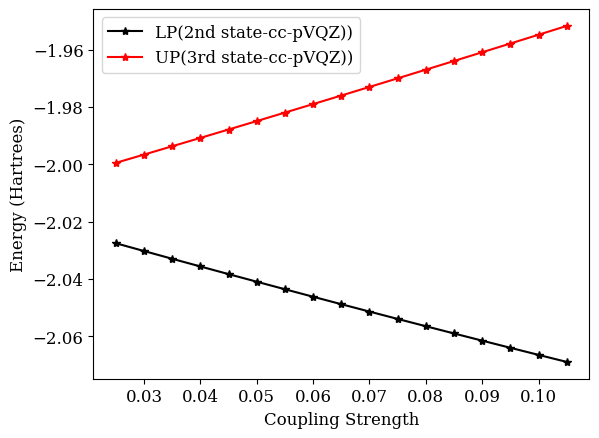

In [13]:
from matplotlib import cm
from matplotlib import rcParams



# plt.plot(lambda_array, _pcqed_22[:,0],'b-', marker="*", label= "Ground State")
# plt.plot(lambda_array, _pcqed_22[:,1], 'm-', marker="*",label = "1st excited state")
plt.plot(lambda_array, _pcqed_22[:,2],'k-', marker="*", label = "LP(2nd state-cc-pVQZ))")
plt.plot(lambda_array, _pcqed_22[:,3],'r-', marker="*", label = "UP(3rd state-cc-pVQZ))")
plt.ylabel('Energy (Hartrees)')
plt.xlabel('Coupling Strength')
plt.legend()
plt.savefig("Energy-vs-Coupling-strength-cc-pVQZ-new-lambda-zoomed", dpi=150)
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
# plt.gca().yaxis.set_major_formatter('{:.12f}'.format)
#plt.plot(A0_list, e4, label = "E4")

plt.show()

In [8]:
# Saving energies in numpy array form
E_pcqed_array = np.array(_pcqed_22)

# Making list from the array
E_list = E_pcqed_array.tolist()

# Making list of lambda value from array
lamda_val = lambda_array.tolist()

# Giving [x, y, z] form to the list
lambda_values = [[0, 0, round(val,3)] for val in lamda_val]


# set up base dictionary - some of this will be updated with each calculation
dictionary = {   
    "molecule": {
        "molecule_name": "HHe+",
        "geometry": [
            "\nH       \nHE            1    0.776011\n1 1\nsymmetry c1\n"
        ],
        "symbols": [
            "H",
            "He"
        ]
    },
       
        "basis_set" : "cc-pVQZ",
        "Photon basis" : "photon_number_basis", 
        "Number Photon States" : 10,
        "driver": "energy",
        "method" : "PCQED",
        "lambda" : lambda_values,
         "omega_value" : '0.9637811053',
    
        "return_result" : E_list,
}


# function to generate file names based on system details
def generate_file_name(dic):
    
    file_name = dic["molecule"]["molecule_name"] + "_"
    file_name += str(dictionary["basis_set"]) + "_"
    file_name += str(dictionary["method"]) + "_"
    file_name += str(dictionary["Number Photon States"]) + "_"
    file_name += str(dictionary["omega_value"]) + ".json"
    return file_name



# write to json file
file_name = generate_file_name(dictionary)
json_object = json.dumps(dictionary, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)

In [ ]:
# # Define the range and increment
# start = 0.0
# stop = 0.02
# increment = 0.001

# # Create the array using numpy's arange function
# lambda_array = np.arange(start, stop + increment, increment)
# print(lambda_array)
# print(len(lambda_array))


# N_R = 21
# d_array = np.linspace(1.4,2.2,N_R)
# N_l = len(lambda_array)
# N_el = 10
# N_ph = 2
# omega = 0.9760568251

# # create an array of zeros to store the PCQED eigenvalues for each value of d
# _pcqed_22 = np.zeros((len(lambda_array),N_l, N_el * N_ph))

# # loop over the lambda values
# for i, lambda_val in enumerate(lambda_array):
#     lambda_vector = np.array([0, 0, lambda_val])
#     ctr = 0
#     for d in d_array:
#         instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr])      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
#         _pcqed_22[ctr, :] = instance.PCQED_pf_eigs
#         ctr += 1


In [ ]:
N_R = 21

d_array = np.linspace(1.0, 3.0, N_R)
N_l = len(d_array)
N_el = 10
N_ph = 2
omega = 0.183747027
lambda_vector = np.array([0, 0, 0.01])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_22 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr])      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_22[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1

In [ ]:
# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_2002_cs = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_cs_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr], neglect_DSE= False)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_2002_cs[ctr, :] = instance.PCQED_cs_eigs
    ctr += 1


In [ ]:
N_el = 100
N_ph = 4
omega = 0.183747027
lambda_vector = np.array([0, 0, 0.01])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_24 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr])      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_24[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1


# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_2004_cs = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_cs_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr], neglect_DSE= False)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_2004_cs[ctr, :] = instance.PCQED_cs_eigs
    ctr += 1


In [ ]:
N_el = 100
N_ph = 6
omega = 0.183747027
lambda_vector = np.array([0, 0, 0.01])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_26 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr])      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_26[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1


# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_2006_cs = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_cs_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr], neglect_DSE= False)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_2006_cs[ctr, :] = instance.PCQED_cs_eigs
    ctr += 1

In [ ]:
N_el = 100
N_ph = 8
omega = 0.183747027
lambda_vector = np.array([0, 0, 0.01])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_28 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr])      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_28[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1


# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_2008_cs = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance.fast_build_pcqed_cs_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr], neglect_DSE= False)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_2008_cs[ctr, :] = instance.PCQED_cs_eigs
    ctr += 1

In [ ]:
# Error = _pcqed_20010_cs[:,0] - _pcqed_210[:,0]
# print(Error)

# abs_error = np.abs(Error)
# mae_10 = np.mean(abs_error)
# print(mae_10)

In [ ]:
# instance.fast_build_pcqed_cs_hamiltonian(2, 2, 0, lambda_vector, E_array[:,0], Mu_array[:,:,:,0], neglect_DSE=False)
# instance.fast_build_pcqed_pf_hamiltonian(2, 2, 0, lambda_vector, E_array[:,0], Mu_array[:,:,:,0], neglect_DSE=False)

# print(instance.PCQED_H_CS)
# print(instance.PCQED_H_PF)

In [ ]:

# Error2 = _pcqed_22[:,0] - _pcqed_2002_cs[:,0]
# # print(Error)

# Error4 = _pcqed_24[:,0] - _pcqed_2004_cs[:,0]
# Error6 = _pcqed_26[:,0] - _pcqed_2006_cs[:,0]
# Error8 = _pcqed_28[:,0] - _pcqed_2008_cs[:,0]
# Error10 = _pcqed_21[:,0] - _pcqed_2001_cs[:,0]


Error2 = _pcqed_22[:,0] - _pcqed_2001_cs[:,0]
# print(Error)

Error4 = _pcqed_24[:,0] - _pcqed_2001_cs[:,0]
Error6 = _pcqed_26[:,0] - _pcqed_2001_cs[:,0]
Error8 = _pcqed_28[:,0] - _pcqed_2001_cs[:,0]
Error10 = _pcqed_21[:,0] - _pcqed_2001_cs[:,0]

In [ ]:
print(Error10)

In [ ]:
from matplotlib import cm
from matplotlib import rcParams


# plt.plot(d_array,np.log(Error2+1e-11),'ro-', label='Np = 2')
# plt.plot(d_array,np.log(Error4+1e-11),'b-', marker="*", label='Np = 4')
# plt.plot(d_array,np.log(Error6+1e-11),'g',  marker="o",label='Np = 6')
# plt.plot(d_array,np.log(Error8 + 1e-11),'k',  marker="d",label='Np = 8')
# plt.plot(d_array,np.log(Error10 +1e-11),'y',  marker=".",label='Np = 10')

plt.plot(d_array,Error2+1e-11,'ro-', label='Np = 2')
plt.plot(d_array,Error4+1e-11,'b-', marker="*", label='Np = 4')
plt.plot(d_array,Error6+1e-11,'g',  marker="o",label='Np = 6')
plt.plot(d_array,Error8 + 1e-11,'k',  marker="d",label='Np = 8')
plt.plot(d_array,Error10 +1e-11,'y',  marker=".",label='Np = 10')
plt.xlabel('Displacement(au)')
plt.ylabel('Error(Hatree)')
plt.yscale('log')
plt.legend()
plt.savefig("error curve new", dpi=150)
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
# plt.gca().yaxis.set_major_formatter('{:.12f}'.format)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.ylim(-30,0)
# plt.xlim(0,20)
# plt.grid()


In [ ]:
Photon_state_basis = [0.0037363329626397706,0.0005036277955904703 , 5.275052548099557e-05, 4.361768495592904e-06, 2.965296325945539e-07, 1.7145714266353893e-08, 1.5631940186722204e-12 ]
photons = [2,3,4,5,6,7,10]



plt.plot(photons,Photon_state_basis,'ro-', label='Photons number basis vs Coherent state basis')
plt.xlabel('No of photons')
plt.ylabel('Error')
plt.savefig("error Photons number basis vs Coherent state basis", dpi=150)
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
plt.gca().yaxis.set_major_formatter('{:.12f}'.format)
plt.legend()

In [ ]:
# plt.plot(d_array, _pcqed_cs_22[:,0],'ro-', label="ground-state_cs")
plt.plot(d_array,_pcqed_22[:,0],'ro-', label='ground-state')
plt.plot(d_array,_pcqed_2002_cs[:,0],'bo-', label='ground-state_cs')
# plt.plot(d_array,_pcqed_22[:,6], 'bo', label='2rd')
# plt.plot(d_array,_pcqed_22[:,7], '-' , label='6th excited')

# plt.plot(lambda_val[:,2],_pcqed_502[:,2],'ro-', label='2nd')
# plt.plot(lambda_val[:,2],_pcqed_502[:,3],'b', label='3rd')
# plt.plot(lambda_val[:,2],_pcqed_502[:,4],'y', label='4th')

plt.xlabel('Displacement')
plt.ylabel('Energy')
# plt.ylim(-113.556, -113.50)
# plt.grid()
plt.savefig("ground state", dpi=150)
#plt.text(1.9, -75.300, "No. of Photons = 5", fontsize=8, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
